In [1]:
# Add the parent directory to sys.path
import sys, os
from pathlib import Path

current_directory = os.getcwd()
parent_directory = Path(current_directory).parent.parent
sys.path.insert(0, str(parent_directory))
sys.path


['c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis',
 'E:\\python_projects\\CVbot',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\notebooks\\user_overview_analysis',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv',
 '',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\Pythonwin']

# Connect to Database

In [2]:
# Load environment variables
from scripts.utils import load_environment_variables

CREDENTIALS = load_environment_variables(parent_directory=parent_directory)

INFO:scripts.utils:Trying to load environment variables from c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis/.env
INFO:scripts.utils:Credentials loaded successfully


In [3]:
# Connect to the database
from scripts.utils import connect_to_database

connection = connect_to_database({"dbname": CREDENTIALS['DB_NAME'],
                                 "user": CREDENTIALS['USER'],
                                 "host": CREDENTIALS['host'],
                                 "port": CREDENTIALS['port']})

INFO:scripts.utils:Attempting to connect to the database
INFO:scripts.utils:Connection successful


In [4]:
# Load the data from the database into a pandas dataframe
from scripts.utils import load_data_from_db
table_name = 'xdr_data'
df = load_data_from_db(conn=connection,
                       table_name=table_name)

INFO:root:Executing query: SELECT * FROM xdr_data
c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis\scripts\utils.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
INFO:scripts.utils:Data loaded into DataFrame successfully


In [5]:
# Close the connection
from scripts.utils import close_database_connection
close_database_connection(conn=connection)

INFO:root:Database connection closed successfully


# Data overview and cleaning

In [6]:
# Import the missing value handler class and create an instance
from scripts.data_processing import MissingValueHandler

handset_df = df[['Handset Type', 'Handset Manufacturer']]
missing_value_handler = MissingValueHandler(handset_df)

INFO:root:MissingValueHandler instance created


In [7]:
# Get summary of missing values
summary = missing_value_handler.missing_value_summary()
summary

INFO:root:Missing value summary computed successfully


Handset Type            572
Handset Manufacturer    572
dtype: int64

In [8]:
# Inspect missing value percentage
percentage = missing_value_handler.missing_value_percentage()
percentage

INFO:root:Missing value percentage computed successfully


Handset Type            0.381331
Handset Manufacturer    0.381331
dtype: float64

- We can see that the missing value percentage is very low

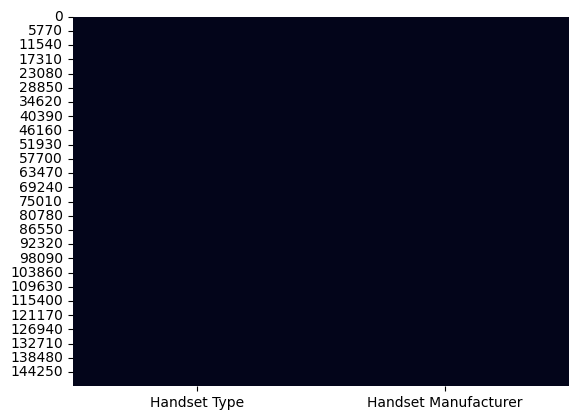

INFO:root:Missing values heatmap displayed successfully


In [9]:
# Show the missing values are very low using heatmap
missing_value_handler.missing_values_heatmap()

- The hitmap also shows most of the data is avaliable and is filled. so we can replace the empty values with `unknown` with out any significant impact on the overall analysis.

In [ ]:
# Replace missing values with unknown
handset_df['Handset Manufacturer'].fillna('unknown', inplace=True)
handset_df['Handset Type'].fillna('unknown', inplace=True)